In [2]:
from nearline_helpers import *
import json
%jsroot on

Welcome to JupyROOT 6.26/10


In [3]:
outfile = 'cosmic_calib.json'
main_outfile = '../bin/detector_mapping.json'

In [4]:
runs = [
    306,
    318
]
t = r.TChain('tree')
for run in runs:
    t.Add(f"../bin/*run*{run}*root")
t.GetEntries()

298839

In [5]:
# cut = "amcNum == 1 && @integrals.size() == 1 && integrals.amcNum == 1"
cut = "integrals.amcNum == 1"

hr = r.TH2D("h", "; Pulse Integral [arb. u.]; Channel Number", 1000,0,200000,5,0,5)
hr2 = r.TH3D("h2", "; Pulse Integral [arb. u.]; Amplitude [ADC Counts/4.096 -> mV]; Channel Number", 1000,0,400000, 1000,0,1000,5,0,5)
t.Draw("integrals.channelTag:integrals.integral>>h", cut,"goff")
t.Draw("integrals.channelTag:integrals.amplitude/4.096:integrals.integral>>h2", cut,"goff")
h = uproot.from_pyroot(hr).to_hist()
h2 = uproot.from_pyroot(hr2).to_hist()
h

Hist(
  Regular(1000, 0, 200000, name=<TString 'xaxis' at 0x7fab28b94950>, label=<TString ' Pulse Integral [arb. u.]' at 0x7fab28b946d0>),
  Regular(5, 0, 5, name=<TString 'yaxis' at 0x7fab28b94150>, label=<TString ' Channel Number' at 0x7fab28b948d0>),
  storage=Double()) # Sum: 782756.0 (786537.0 with flow)

In [6]:
cosmic_peak = 22 # MeV
amc = 1
crate = 0
channels = range(5)

channel_range = {
    0:[70000,150000],
    1:[70000,150000],
    2:[70000,150000],
    3:[70000,150000],
    4:[70000,150000],
}

In [7]:
from g2fit.fitting import PyFit
import g2fit.functions 

def peak_fit(x,p):
    gaus_params = p[:4]
    # poln_params = p[4:]
    # expo_params = p[4:]
    # print(expo_params)
    # return g2fit.functions.gaus(x,gaus_params) + g2fit.functions.poln(x,poln_params)
    # return g2fit.functions.gaus(x,gaus_params) + g2fit.functions.expo(x,expo_params)
    return g2fit.functions.gaus(x,gaus_params) 

100200.0


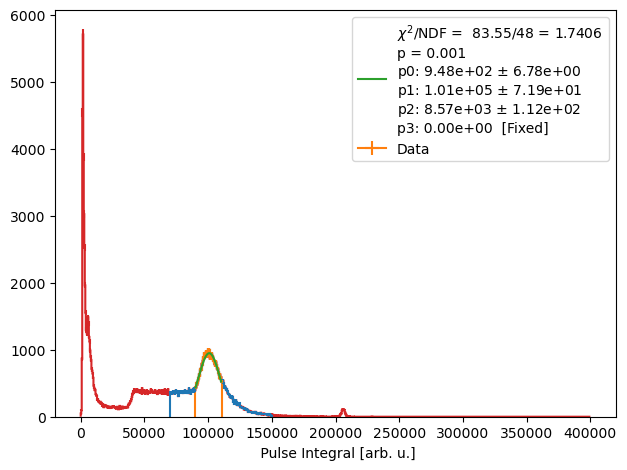

107000.0


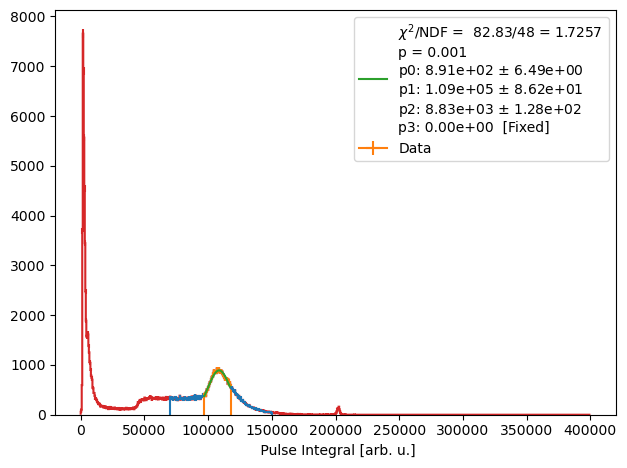

100600.0


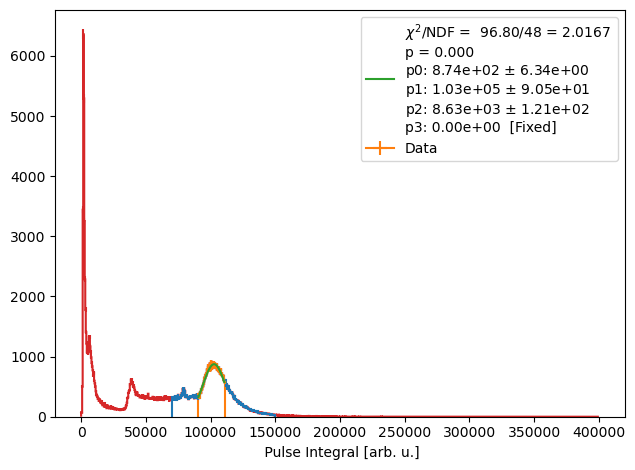

108600.0


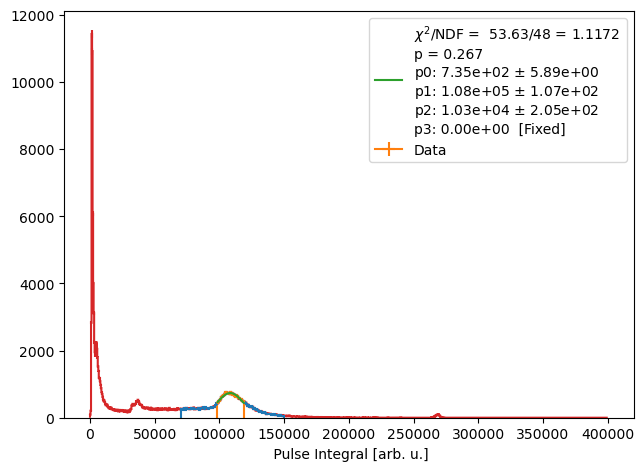

93400.0


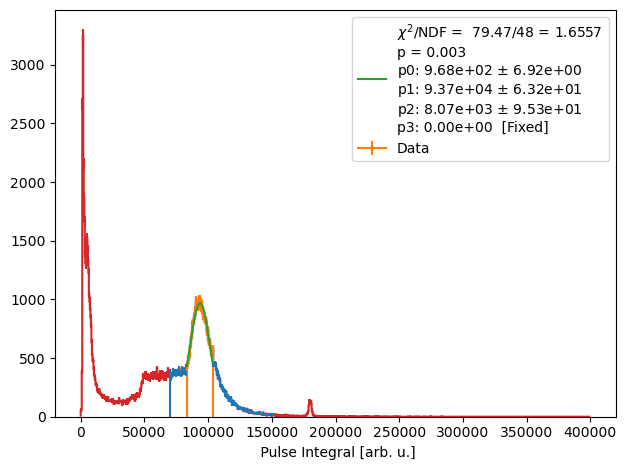

{(0, 1, 0): 100865.92645627336,
 (0, 1, 1): 108605.20547501785,
 (0, 1, 2): 102724.2970100363,
 (0, 1, 3): 108367.42113027633,
 (0, 1, 4): 93654.86208708677}

In [8]:
peaks = {}
for channel in channels:
    hi = h2[:,::sum,hist.loc(channel)]
    hi2 = hi[hist.loc(channel_range[channel][0]):hist.loc(channel_range[channel][1])]
    max_bin = hi2.axes[0].centers[list(hi2.values()).index(np.amax(hi2.values()))]
    print(max_bin)

    fiti = PyFit.from_hist(
        hi2,
        peak_fit,
        [
            np.amax(hi2.values()), 90000, 10000, 0, 
            # 1000, 1000000,10
        ],
        par_limits={
            # 0:[0,None],
            # 4:[0,None],
            # 5:[1,None],
        },
        limits=(max_bin-10000, max_bin+10000),
        strip_nans=True
    )
    fiti.m.fixed[3] = True
    fiti.fit()
    fiti.simple_plot()
    hi.plot(zorder=0)
    plt.show()
    
    peaks[(crate,amc,channel)] = fiti.m.values[1]
peaks

In [9]:
calib = {}
for id, peak in peaks.items():
    calib[id] = cosmic_peak/peak
calib

{(0, 1, 0): 0.00021811131640710478,
 (0, 1, 1): 0.00020256855924885293,
 (0, 1, 2): 0.00021416549580135428,
 (0, 1, 3): 0.0002030130436854468,
 (0, 1, 4): 0.00023490504934535995}

In [10]:
calib = {}
for id, peak in peaks.items():
    calib[id] = cosmic_peak/peak
calib

{(0, 1, 0): 0.00021811131640710478,
 (0, 1, 1): 0.00020256855924885293,
 (0, 1, 2): 0.00021416549580135428,
 (0, 1, 3): 0.0002030130436854468,
 (0, 1, 4): 0.00023490504934535995}

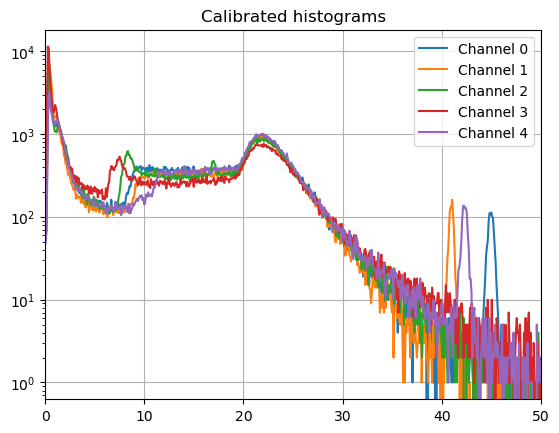

In [11]:
fig,ax = plt.subplots()
for id,ci in calib.items():
    channel = id[-1]
    hi = h2[:,::sum,hist.loc(channel)]
    plt.plot(hi.axes[0].centers * ci, hi.values(), label=f'Channel {channel}'  )
plt.legend()
plt.grid()
plt.xlim(0,50)
plt.yscale("log")
plt.title("Calibrated histograms")
plt.show()

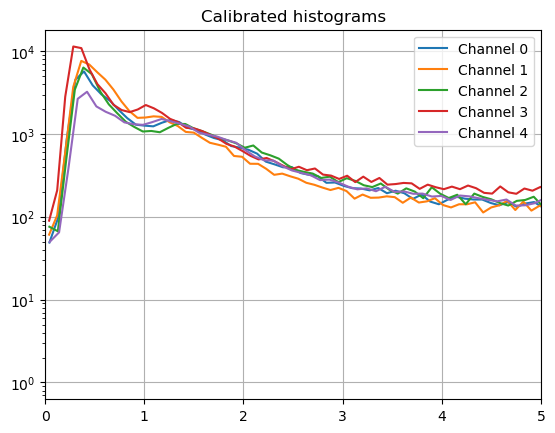

In [12]:
fig,ax = plt.subplots()
for id,ci in calib.items():
    channel = id[-1]
    hi = h2[:,::sum,hist.loc(channel)]
    plt.plot(hi.axes[0].centers * ci, hi.values(), label=f'Channel {channel}'  )
plt.legend()
plt.grid()
plt.xlim(0,5)
plt.yscale("log")
plt.title("Calibrated histograms")
plt.show()

In [13]:
calib

{(0, 1, 0): 0.00021811131640710478,
 (0, 1, 1): 0.00020256855924885293,
 (0, 1, 2): 0.00021416549580135428,
 (0, 1, 3): 0.0002030130436854468,
 (0, 1, 4): 0.00023490504934535995}

In [14]:
# cut = "amcNum == 1 && @integrals.size() == 1 && integrals.amcNum == 1"
cut = "integrals.amcNum == 1"

h3 = hist.Hist(
    hist.axis.Regular(1000,0,100,label='Original Calibration'),
    hist.axis.Regular(1000,0,100,label='New Calibration'),
    hist.axis.IntCategory(range(5),label='Channel Number')
)
for i, e in enumerate(t):
    for j, wfj in enumerate(e.integrals):
        h3.fill(
            e.integrals_calibrated[j].integral,
            wfj.integral * calib[(0,1,wfj.channelTag)],
            wfj.channelTag
        )
h3


Hist(
  Regular(1000, 0, 100, label='Original Calibration'),
  Regular(1000, 0, 100, label='New Calibration'),
  IntCategory([0, 1, 2, 3, 4], label='Channel Number'),
  storage=Double()) # Sum: 786613.0 (786660.0 with flow)

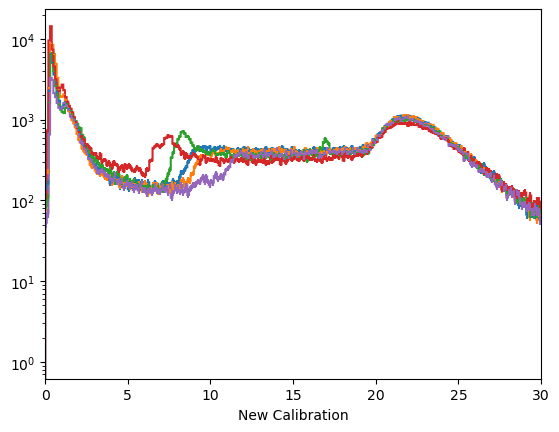

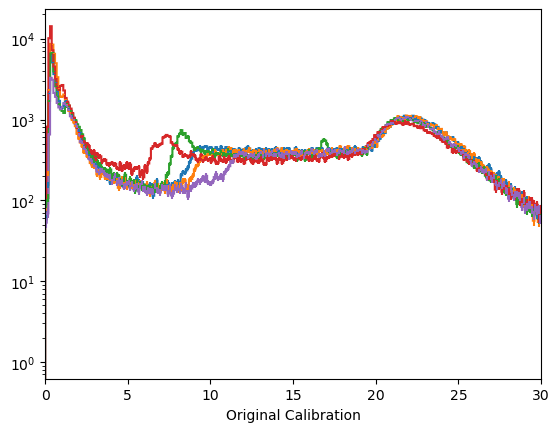

In [15]:
h3[::sum,...].stack(1).plot()
plt.yscale("log")
plt.xlim(0,30)
plt.show()

h3[:,::sum,:].stack(1).plot()
plt.yscale("log")
plt.xlim(0,30)
plt.show()

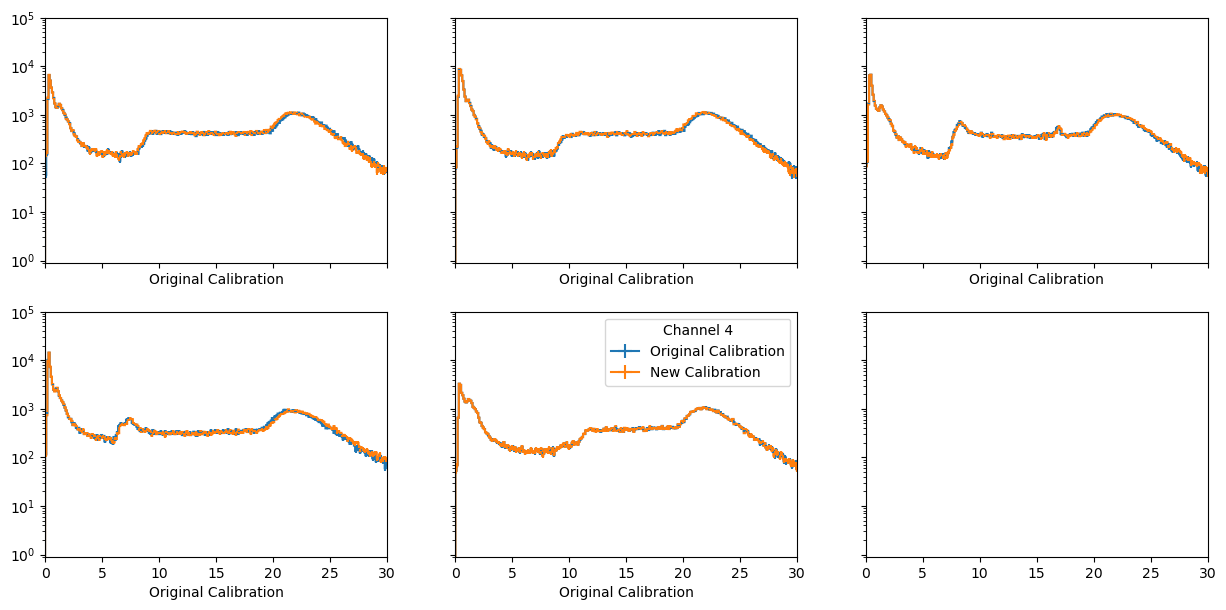

In [16]:
fig,ax = plt.subplots(2,3,figsize=(15,7),sharex=True,sharey=True)
for channel in h3.axes[-1]:
    axi = ax.ravel()[channel]
    plt.sca(axi)
    h3[:,::sum,hist.loc(channel)].plot(label=h3.axes[0].label,ax=axi)
    h3[::sum,:,hist.loc(channel)].plot(label=h3.axes[1].label,ax=axi)
plt.yscale("log")
plt.ylim(0.9,1e5)
plt.xlim(0,30)
plt.legend(title=f'Channel {channel}')
plt.show()

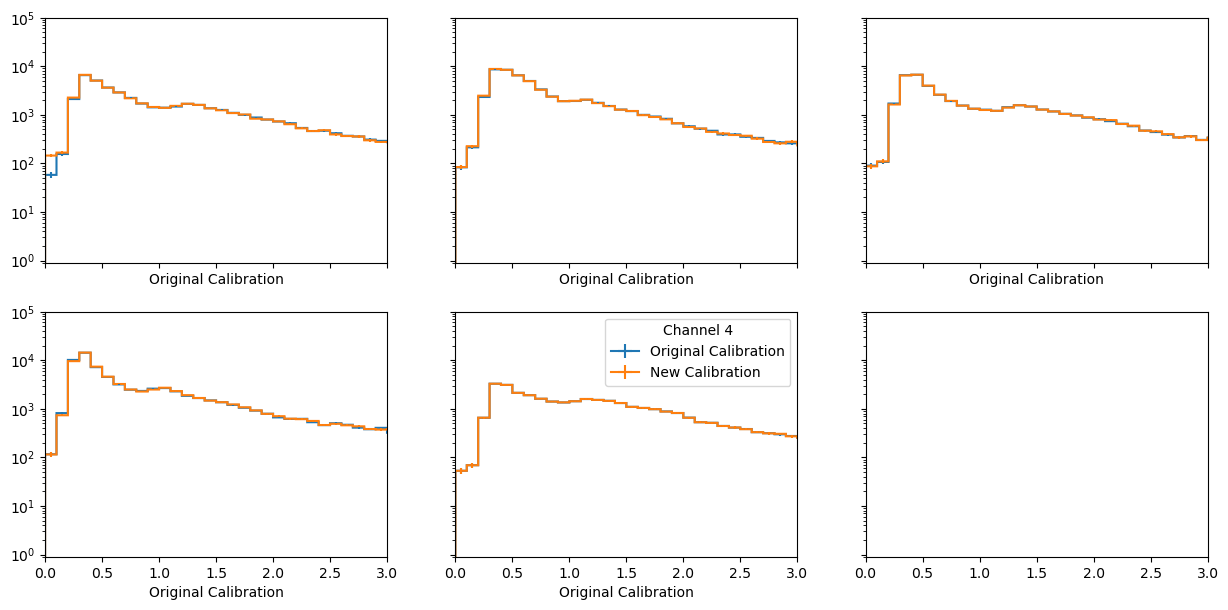

: 

In [17]:
fig,ax = plt.subplots(2,3,figsize=(15,7),sharex=True,sharey=True)
for channel in h3.axes[-1]:
    axi = ax.ravel()[channel]
    plt.sca(axi)
    h3[:,::sum,hist.loc(channel)].plot(label=h3.axes[0].label,ax=axi)
    h3[::sum,:,hist.loc(channel)].plot(label=h3.axes[1].label,ax=axi)
plt.yscale("log")
plt.ylim(0.9,1e5)
plt.xlim(0,3)
plt.legend(title=f'Channel {channel}')
plt.show()

In [21]:
c = r.TCanvas()
hr3.Draw()
c.Draw()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9d80cffc10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

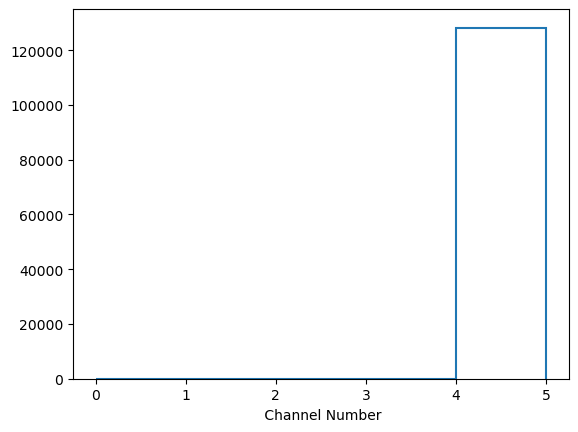

In [20]:
h3.project(1).plot()

/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


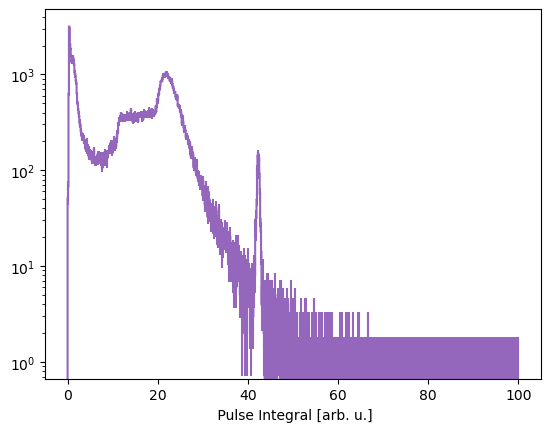

In [15]:
h3.stack(1).plot()
plt.legend()
plt.yscale("log")
plt.show()

/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


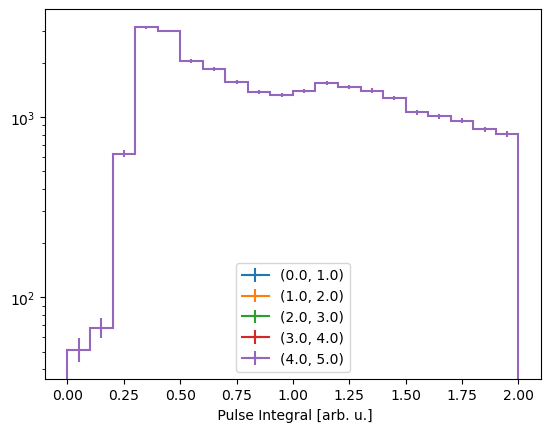

In [17]:
h3[:2j,:].stack(1).plot()
plt.legend()
plt.yscale("log")
plt.show()

---

### Export the calibration constants

In [97]:
#create the baseline file structure
# for (crate, amc,channel),diffi in diffs.items():
dicti = {'energy_calibration':[]}
for crate in [0]:
    for amc in range(1,13):
        for channel in range(5):
            dicti['energy_calibration'].append({
                "crateNum":crate,
                "amcSlotNum":amc,
                "channelNum":channel,
                # "pedestal_raw":round(ped,3),
                # "pedestal":round(ped,0),
                "energy_calibration":calib.get((crate, amc,channel), 1.0),
            })


with open(outfile, 'w') as fout:
    json.dump(dicti, fout, indent=3)

In [101]:
with open(main_outfile, 'r') as fin:
    existing_config = json.load(fin)
print(existing_config['calibration'])

for i,x in enumerate(existing_config['calibration']):
    this_tag = (x['crateNum'], x['amcSlotNum'], x['channelNum'])
    if(this_tag in calib):
        existing_config['calibration'][i]['energy_calib'] = calib[this_tag]
print(existing_config['calibration'])


[{'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 1, 'channelNum': 0}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 1, 'channelNum': 1}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 1, 'channelNum': 2}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 1, 'channelNum': 3}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 1, 'channelNum': 4}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 2, 'channelNum': 0}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 2, 'channelNum': 1}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 2, 'channelNum': 2}, {'energy_calib': 1.0, 'time_calib': 1.0, 'time_offset': 0.0, 'crateNum': 0, 'amcSlotNum': 2, 'channelNum': 3}, 

In [103]:
with open(main_outfile, 'w') as fout:
    json.dump(existing_config,fout,indent=3)